## Prepare the data

### 1. Load the fine-tuning data

In [1]:
import json

file_path = "../output/fine_tuning/data/fine_tuning.json"
with open(file_path, "r") as file:
    data = json.load(file)

### 2. Load the tokenizer

In [2]:
import sys
sys.path.append('..')

In [3]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/darija_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. Tokenize the sequences

In [4]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

74

### 4. Split the data

We need to be careful when splitting the data. We want to keep the multi-turn conversations complete in each part. So, the training and validation sets should start with a `You` message and end with an `Assistant` message.

In [5]:
initial_split_index = int(0.95 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>La Wikipedia Del Porno(Andres)'):
    split_index -= 1

train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

Training set: 
Start message: <|startoftext|>La Wikipedia Del Porno(Andres)
End message: <|startoftext|>La Wikipedia Del Porno(Andres)

Validation set: 
Start message: <|startoftext|>Pedro Guill Ferri
End message: <|startoftext|>La Wikipedia Del Porno(Andres)


We got the index that we should use to split the data. Now, let's split the tokenized data.

In [6]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

Now, we need to combine the `You` and `Assistant` turns into one sequence. We will make sure that the resulting sequence does not exceed the `block_size`.

In [7]:
block_size = 256


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [8]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 10405
Length after: 5202

Validation data
Length before: 548
Length after: 274


Let's convert each sequence of tokens into a tensor.

In [9]:
# import torch

# train_data = torch.tensor(combined_train_data)
# val_data = torch.tensor(combined_val_data)

Since our token sequences don't all have the same length, we can't turn the data into a tensor all at once. To do that, all sequences need to have the same length.

That's why we need to use padding to fix this problem. We can add padding at the start or end of the sequence. Let's add it to the start.

In [10]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=combined_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=combined_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

(torch.Size([5202, 256]), torch.Size([274, 256]))

In [11]:
train_data_tensor[0]

tensor([16384,  4659,  2435,   105,  5291,   351,  1433,  5570,   551,   788,
           40,    65,   110,  4591,    41, 16385,    87,   101,   752,    84,
          101,   421,   114,   671,   752,    65,  5613,    10,    79,  5613,
           42,    10,    83,   111,   375,   442,   325,  3903,   524,   620,
           10, 11839,   111,   277,   268,  4452,   258,   476,   272,  1464,
          111,   348,   258,  1750,   415,   277,   669,  1424,   330,   361,
          334,  4492,   415,   258,   476,   272,    10,    72,   282,  7985,
         1389,   347,    63, 16386, 16384,    80,   101,  4556,   568,   373,
         1025, 16348, 16385,    83,   105, 16386, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 

In [12]:
val_data_tensor[0]

tensor([16384,    80,   101,  4556,   568,   373,  1025, 16348, 16385, 11391,
          293,  6140,   367,   263,  9592,   263,   706,  9356,   443,  2692,
          262, 16386, 16384,  4659,  2435,   105,  5291,   351,  1433,  5570,
          551,   788,    40,    65,   110,  4591,    41, 16385,    83,   105,
        16386, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388,
        16388, 16388, 16388, 16388, 16388, 16388, 16388, 16388, 

### 5. Creat the data loaders

In [13]:
train_data_tensor.shape

torch.Size([5202, 256])

In [14]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [15]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 256]), torch.Size([64, 256]))

## Fine-tuning with LoRA

### 1. Load the saved checkpoint

In [16]:
from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 512
n_head = 8
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

29.539338 M parameters


In [18]:
checkpoint_path = "../output/pre_training/base_model_checkpoint.pth"
checkpoint = torch.load(
    checkpoint_path, weights_only=True, map_location=device)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

RuntimeError: Error(s) in loading state_dict for OptimizedModule:
	size mismatch for _orig_mod.token_embedding_table.weight: copying a param with shape torch.Size([1034, 512]) from checkpoint, the shape in current model is torch.Size([16394, 512]).
	size mismatch for _orig_mod.final_linear_layer.weight: copying a param with shape torch.Size([1034, 512]) from checkpoint, the shape in current model is torch.Size([16394, 512]).
	size mismatch for _orig_mod.final_linear_layer.bias: copying a param with shape torch.Size([1034]) from checkpoint, the shape in current model is torch.Size([16394]).

### 2. Add LoRA layers

In [ ]:
from transformer.lora import get_lora_model, print_trainable_parameters

lora_model = get_lora_model(
    model=model,
    lora_config={
        "rank": 4,
        "alpha": 8,
    },
    device=device,
)
print_trainable_parameters(lora_model)

All parameters: 14.12M | Trainable parameters: 0.33M | Trainable %: 2.31%


Generate from the model to make sure that the weights were loaded correctly.

In [ ]:
input_tokens = tokenizer.encode("Hola ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Hola Chale Si Seee Q putas pear contra nosotros 2 xD Chale Busca xD Si xD Puta essiempre de lognifica que erte xD Moto hale xD Si xD Rafa enos paja xD Brutal amente el chiston porno El uscame pero tambien xD Si xD Remetor Un puñ no tiene nada que es de gt se han hechizo clase 


In [ ]:
input_tokens = tokenizer.encode("Hola ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

lora_model.eval()
with torch.no_grad():
    output = lora_model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Hola si ya esta llendo manga Que Si Pues ya la tengo el conecta 15 años Pepe Que ya me estoda la temporada 3 años nuevo asi compraste mi cuenta por qué no hay una vez te lista cuando tengas un pc porno de pj en que e vuelvo a empezar el mismo alidad para que vuelvo a empezar el pc Duro Si Pues si no es tal Ok Ahora si Ok Es porque pez


### 3. Estimate loss

In [ ]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

### 4. Save checkpoints

In [ ]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 5. Training loop

In [ ]:
max_iters = 10
eval_interval = 10
learning_rate = 1e-4

optimizer = torch.optim.AdamW(lora_model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=lora_model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = lora_model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=lora_model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../output/fine_tuning/adapters/run_1/checkpoint_{iteration}.pth"
    )

iteration 0 / step 0: train loss 10.4962, val loss 10.6630
iteration 0 / step 10: train loss 3.4523, val loss 4.0698
iteration 0 / step 20: train loss 2.7472, val loss 3.5044
iteration 0 / step 30: train loss 2.3696, val loss 3.1571
iteration 0 / step 40: train loss 2.2225, val loss 2.9371
iteration 0 / step 50: train loss 2.1410, val loss 2.9390
iteration 0 / step 60: train loss 2.0895, val loss 2.9345
iteration 0 / step 70: train loss 2.0416, val loss 2.8922
iteration 0 / step 80: train loss 2.0142, val loss 2.9152
iteration 0 / step 81: train loss 2.0142, val loss 2.9002
iteration 1 / step 0: train loss 2.0158, val loss 2.8949
iteration 1 / step 10: train loss 1.9905, val loss 2.8754
iteration 1 / step 20: train loss 1.9659, val loss 2.8883
iteration 1 / step 30: train loss 1.9466, val loss 2.8849
iteration 1 / step 40: train loss 1.9381, val loss 2.9089
iteration 1 / step 50: train loss 1.9254, val loss 2.8904
iteration 1 / step 60: train loss 1.9273, val loss 2.8772
iteration 1 / 

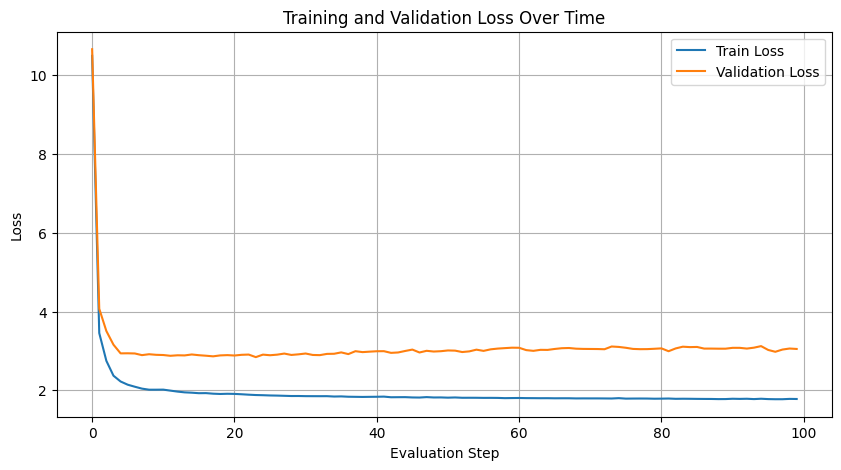

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "Hola"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

lora_model.eval()
while True:
    output_tokens = lora_model.generate(
        input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        input_tokens = input_tokens[:, -block_size:]

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: Hola
Assistant: Wikipedia Del Porno(Andres)<|separator|>Y puedo
Sigúl la el perdía más prómo val de si vilg cuán de cos y Conde mama no ultima manga de r como
